In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [58]:
#importing HDFC stock price dataset till 2021 April
import pandas as pd
dataset=pd.read_csv('/content/gdrive/My Drive/datasets/HDFC.csv')

In [4]:
# Dataset of HDFC closing prices only
df=dataset.iloc[:,[8]]

In [66]:
# Checking for null values in dataset
df.head()
df["Close"].isna().sum()

0

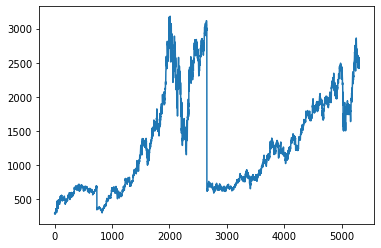

In [6]:
import matplotlib.pyplot as plt
plt.plot(df)

In [7]:
import numpy as np

In [8]:
# Scaling the data
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df).reshape(-1,1))

In [9]:
# Splitting the dataframe
training_size=int(len(df1)*0.65)
test_size=int(len(df1)*0.35)
train_data,test_data=df1[0:training_size],df1[training_size:len(df1)]

In [10]:
# Creating sequential data for LSTM with time_step=100
def create_dataset(dataset,time_step=1):
  dataX,dataY=[],[]
  for i in range(len(dataset)-time_step-1):
    a=dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i+time_step,0])
  return np.array(dataX),np.array(dataY)

In [11]:
time_step=100
X_train,y_train=create_dataset(train_data,time_step)
X_test,y_test=create_dataset(test_data,time_step)

In [68]:
print(X_train.shape)

(3347, 100, 1)


In [13]:
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM


In [41]:
# Stacked LSTM model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(30))
model.add(Dense(1))
model.compile(loss="mean_squared_error",optimizer="adam")


In [42]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 100, 50)           10400     
                                                                 
 lstm_16 (LSTM)              (None, 30)                9720      
                                                                 
 dense_4 (Dense)             (None, 1)                 31        
                                                                 
Total params: 20,151
Trainable params: 20,151
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 80, batch_size = 60, verbose = 1)

Epoch 1/80
56/56 [==============================] - 6s 34ms/step - loss: 0.0137 - val_loss: 6.9078e-04
Epoch 2/80
56/56 [==============================] - 1s 12ms/step - loss: 0.0021 - val_loss: 6.3436e-04
Epoch 3/80
56/56 [==============================] - 1s 11ms/step - loss: 0.0019 - val_loss: 7.6404e-04
Epoch 4/80
56/56 [==============================] - 1s 11ms/step - loss: 0.0018 - val_loss: 9.3431e-04
Epoch 5/80
56/56 [==============================] - 1s 12ms/step - loss: 0.0016 - val_loss: 4.4135e-04
Epoch 6/80
56/56 [==============================] - 1s 12ms/step - loss: 0.0015 - val_loss: 6.1520e-04
Epoch 7/80
56/56 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 3.6718e-04
Epoch 8/80
56/56 [==============================] - 1s 11ms/step - loss: 0.0012 - val_loss: 5.1365e-04
Epoch 9/80
56/56 [==============================] - 1s 12ms/step - loss: 0.0012 - val_loss: 3.5534e-04
Epoch 10/80
56/56 [==============================] - 1s 11ms/step - loss:

In [44]:

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

55/55 [==============================] - 0s 4ms/step


In [45]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [46]:
scaler.inverse_transform(y_train.reshape(-1,1))

array([[543.65],
       [478.45],
       [496.35],
       ...,
       [795.2 ],
       [819.45],
       [821.15]])

In [47]:
# Calculating rmse value for train and test data
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(scaler.inverse_transform(y_train.reshape(-1,1)), train_predict))

57.13417684984036

In [48]:
math.sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(-1,1)), test_predict))


38.068953231073145

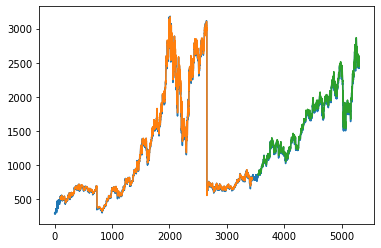

In [49]:
# Plotting the predicted values on actual values
look_back = 100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

#Shift test prediction for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2)+1:len(df) - 1, :] = test_predict

#Plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [69]:

len(test_data), X_test.shape


(1858, (1757, 100, 1))

In [51]:

x_input = test_data[1758:].reshape(1,-1)
x_input.shape

(1, 100)

In [52]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [53]:
# Predicting next 50 days closing price of the stock
lst_output=[]
n_steps=100
nextNumberOfDays = 50
i=0

while(i<nextNumberOfDays):
    
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.74367857]
101
1 day input [0.67743328 0.6974243  0.69947865 0.69842558 0.69234886 0.69469668
 0.69702724 0.71349653 0.73914995 0.76330145 0.75805338 0.73574906
 0.73189932 0.73169216 0.74968063 0.75703484 0.77170873 0.77139799
 0.78541588 0.78890308 0.79226945 0.81759486 0.81310638 0.82087491
 0.81954563 0.85189725 0.85063702 0.82417222 0.8287125  0.81100024
 0.78812623 0.81935573 0.83012809 0.8214446  0.79605013 0.78291268
 0.75377205 0.73952974 0.72297414 0.7925284  0.82006353 0.83544522
 0.83689535 0.84164279 0.84573421 0.85046439 0.85738701 0.85514277
 0.86581155 0.88961779 0.88899631 0.87059352 0.84980838 0.84847909
 0.81762939 0.80956738 0.83689535 0.82893692 0.77876946 0.80176432
 0.78726306 0.81864793 0.79380589 0.78032317 0.7687049  0.79185513
 0.79962366 0.78864413 0.77742292 0.76875669 0.77053482 0.77020682
 0.77609364 0.77616269 0.76858406 0.75334047 0.75506681 0.77647343
 0.80164348 0.76450989 0.77602458 0.74646963 0.75560197 0.75919276
 0.76604633 0.76996513 0.73749266

In [54]:
day_new = np.arange(1,101)
day_pred = np.arange(101,151)

In [55]:
len(df1)

5306

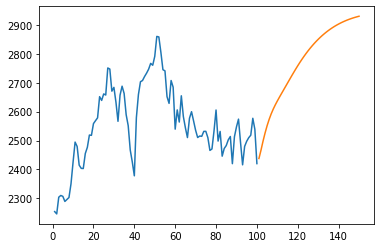

In [56]:
# Plotting the prediction for next 50 days
plt.plot(day_new, scaler.inverse_transform(df1[5206:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))


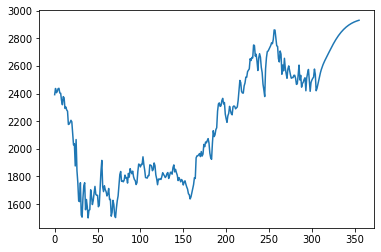

In [57]:
df3 = df1.tolist()
df3.extend(lst_output)
plt.plot(scaler.inverse_transform(df3[5000:]))